### Household Sounds Capstone
## 5. Modeling

This notebook is broken up into three sections for the three sets of extracted features: Mel-Frequency Spectrograms, MFCC Spectrograms, and the mean MFCC values. All models with have the same response variable of the audio class label. The evaluation metric will optimize for is accuracy, with the ultimate goal of obtaining the highest F1-score on the test dataset.

#### Part 1: Mel-Frequency Spectrogram Features
- Model 1a: Convolutional Neural Network 

#### Part 2: MFCC Sprectrogram Features
- Model 2a: Convolutional Nueral Network
- Model 2b: CNN with Resnet50 Tranfering Learning 

#### Part 3: Mean MFCC Values Features
- Model 3a: Neural Network
- Model 3b: Logistic Regression
- Model 3c: Random Forest
- Model 4b: Support Vector Machine

In [1]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle
import keras
import tensorflow as tf
from keras.models import Sequential
from keras import Model
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, LeakyReLU,BatchNormalization
from keras.utils import to_categorical
from keras.optimizers import Adam, SGD
from keras.losses import sparse_categorical_crossentropy
from keras.callbacks import EarlyStopping
from keras.applications.resnet50 import ResNet50
from keras import Model
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from scipy.stats import reciprocal, uniform
from  sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from  sklearn.ensemble import RandomForestClassifier

# loading custom functions from custom_funcs.py
from custom_funcs import predictions_with_classification_report, plot_history, plot_confusion_matrix

#### Loading Training and Test Data
- Given the imbalanced classes that the training data contained, all modeling with but done using the resampled training dataset with under sampling and over sampling with data augmentation.

In [4]:
dev_info_resampled = pd.read_json('data/dev_info_resamp.json')
eval_info = pd.read_json('data/labelled_eval_info.json')

In [5]:
print(dev_info_resampled.shape)
print(eval_info.shape)
eval_info.head()

(40000, 3)
(10231, 5)


,description,tags,track_num,png_name,labels
391277,An other birds singings recorded on the mornin...,"[birdsong, bird, forest, environment, morning,...",391277,391277.png,2
392115,a snap of one's fingers,"[fingers, finger, 5maudio17, uam, fingersnap]",392115,392115.png,1
411438,A sound of Hot water pouring into a cup,"[fill, can, beverage, glass, water, pour, drin...",411438,411438.png,1
395238,Tearing papers with reverb.\r\n\r\nI used a Sa...,"[ripping, papier, paper, scheuren, rip, tearing]",395238,395238.png,1
425681,i recorded me sighing.,"[sad, happy, sigh]",425681,425681.png,1


#### Loading Validation-Test-Split for Convolutional Neural Networks

In [6]:
validation_info= pd.read_json('data/validation_info.json')
test_info = pd.read_json('data/test_info.json')

In [7]:
print(validation_info.shape)
print(test_info.shape)
test_info.head()

(5115, 5)
(5116, 5)


,description,tags,track_num,png_name,labels
5115,A toilet flushed and refilling.,"[empty, field-recording, fill, flush, toilet, ...",126046,126046.png,1
5116,The sound of a sharp knife cutting a provita o...,"[kitchen, knife, provita, crackers, sharp, boa...",365562,365562.png,1
5117,The sound is dropping a spoon into a cup of co...,"[hit, room, cup, metal, upf-cs13, dining, spoo...",186347,186347.png,1
5118,skin pat touch hand,"[touch, hand, pat, skin]",349897,349897.png,7
5119,You can hear some coins droping on the floor. ...,"[floor, coin, coins, money]",360908,360908.png,1


In [ ]:
# loading dictionary for storing model metrics
metrics_dict = pickle.load(open('./models/model_metrics_dict.pkl', 'rb'))

___
### Part 1a: Mel-Frequency Spectogram Features
### Model: Convolutional Neural Network

### Loading Spectrograms with Keras Generators:

In [8]:
# load data into generator with keras function: .flow_from_directory()

datagen=ImageDataGenerator(rescale=1./255.) 

# train generator
train_spectrogram_generator=datagen.flow_from_dataframe(
    # dataframe with filenames and response variable
    dataframe= dev_info_resampled,
    # directory with spectrogram images
    directory= 'data/train_spectrograms',
    # spectrogram file name
    x_col='png_name',
    # response variable
    y_col= 'labels', 
    # importing images as grayscale, spectrograms are created 
    # based on audio intensity, does not required 3 channels 
    color_mode="grayscale",
    batch_size=32,
    seed=42,
    # shuffling the training data, but not shuffling test data to compare with y_test true values
    shuffle=True,
    # raw for numeric input for categorical response variable
    class_mode=  "raw", 
    #dimensions of spectrogram image: 128 Mel-Frequency Bands by 216 23-millisecond sound events (5 seconds)
    target_size=(128,216), 
    validate_filenames=True) 

# validation generator
val_spectrogram_generator=datagen.flow_from_dataframe(
    dataframe= validation_info,
    directory= 'data/test_spectrograms',
    x_col='png_name',
    y_col= 'labels', 
    color_mode="grayscale",
    batch_size=32,
    seed=42,
    shuffle=False,
    class_mode= "raw", 
    target_size=(128,216),
    validate_filenames=True) 

# test generator
test_spectrogram_generator=datagen.flow_from_dataframe(
    dataframe= test_info,
    directory= 'data/test_spectrograms',
    x_col='png_name',
    y_col= 'labels',
    color_mode="grayscale",
    batch_size=32,
    seed=42,
    shuffle=False,
    class_mode=  "raw", 
    target_size=(128,216),
    validate_filenames=True) 

Found 40000 validated image filenames.
Found 5115 validated image filenames.
Found 5116 validated image filenames.


### Defining Convolutional Neural Network Model

In [9]:
#Define Model
model = Sequential()

model.add(Conv2D(16, kernel_size=(3, 3), activation='relu', padding="same", input_shape=(128,216,1))) 
model.add(MaxPooling2D(pool_size=(1, 2)))
model.add(Conv2D(16, kernel_size=(3, 3), padding="same", activation='relu')) 
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, kernel_size=(3, 3), padding="same", activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, kernel_size=(3, 3), padding="same", activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(8, activation='softmax'))

model.compile(loss=sparse_categorical_crossentropy, 
              optimizer=SGD(lr=0.002, decay=1e-6, momentum=0.9, nesterov=True), 
              metrics='accuracy')

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 216, 16)      160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 108, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 108, 16)      2320      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 54, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 54, 32)        4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 27, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 27, 32)        9

In [10]:
#Train and Test The Model
start= time.time()
history = model.fit(x=train_spectrogram_generator, 
                    validation_data=val_spectrogram_generator, 
                    epochs=40, 
                    verbose=1)    

end =time.time()
print(end-start)

Epoch 1/40
1250/1250 [==============================] - 120s 96ms/step - loss: 1.9873 - accuracy: 0.2110 - val_loss: 3.7465 - val_accuracy: 0.0219
Epoch 2/40
1250/1250 [==============================] - 121s 97ms/step - loss: 1.6363 - accuracy: 0.4021 - val_loss: 2.2605 - val_accuracy: 0.2010
Epoch 3/40
1250/1250 [==============================] - 121s 97ms/step - loss: 1.4312 - accuracy: 0.4750 - val_loss: 3.3218 - val_accuracy: 0.1390
Epoch 4/40
1250/1250 [==============================] - 121s 97ms/step - loss: 1.3367 - accuracy: 0.5182 - val_loss: 1.5994 - val_accuracy: 0.4334
Epoch 5/40
1250/1250 [==============================] - 121s 97ms/step - loss: 1.2726 - accuracy: 0.5397 - val_loss: 1.8032 - val_accuracy: 0.3486
Epoch 6/40
1250/1250 [==============================] - 121s 97ms/step - loss: 1.2237 - accuracy: 0.5587 - val_loss: 1.8322 - val_accuracy: 0.3093
Epoch 7/40
1250/1250 [==============================] - 121s 97ms/step - loss: 1.1820 - accuracy: 0.5717 - val_loss: 1

### Model Analysis

classification Report:
              precision    recall  f1-score   support

           0       0.45      0.65      0.53       705
           1       0.70      0.44      0.54      2163
           2       0.35      0.40      0.37       405
           3       0.61      0.71      0.65       562
           4       0.38      0.60      0.46       750
           5       0.26      0.23      0.24       193
           6       0.25      0.43      0.32        44
           7       0.06      0.04      0.05       294

    accuracy                           0.49      5116
   macro avg       0.38      0.44      0.40      5116
weighted avg       0.53      0.49      0.49      5116



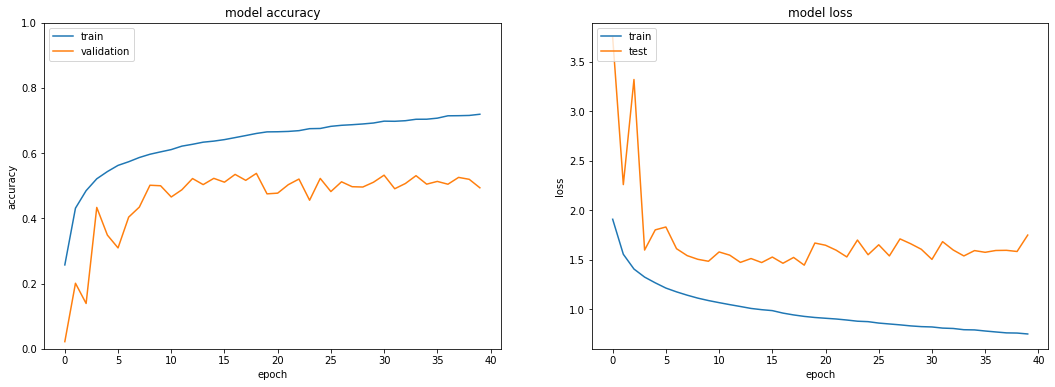

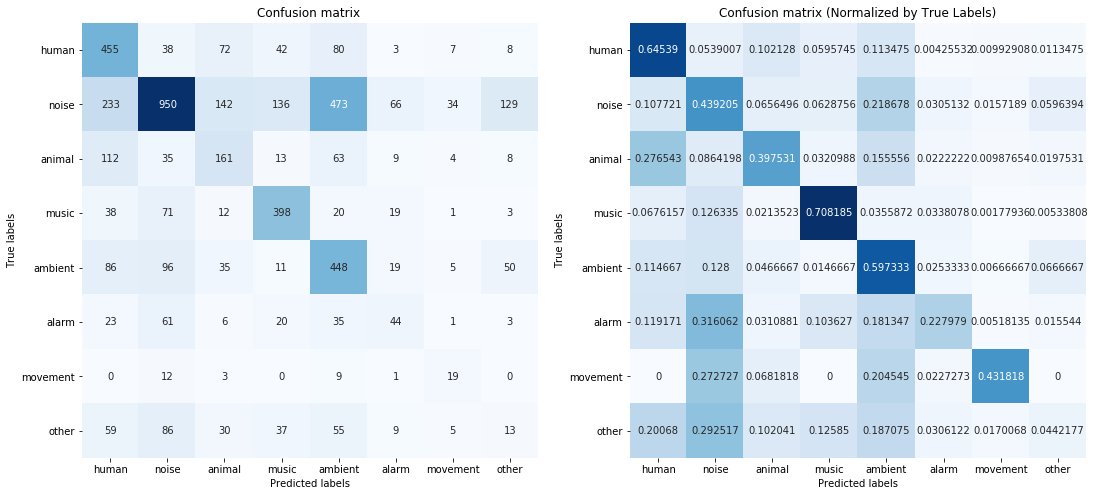

In [11]:
# making predictions on test data and printing classification report:
spectrogram_preds = predictions_with_classification_report(model=model, 
                                                           generator=test_spectrogram_generator, 
                                                           y_true=test_info.labels)

# plotting model accuracy for training and validation data:
plot_history(history=history)

# plotting a normalizing and non-normalizing confusion matrix::
plot_confusion_matrix(y_true=test_info.labels, y_preds=spectrogram_preds)

#### Saving Model

In [12]:
# saving model and model history:
model.save("./data/cnn_spectrogram_model.h5")
pickle.dump(history.history, open('./data/cnn_spectrogram_model_history.pkl', 'wb'))   
print("Saved model to disk") 

# saving model metrics dictionary
metrics_dict['cnn_spectrogram_model'] = precision_recall_fscore_support(test_info.labels, spectrogram_preds, 
                                                                        average='macro')
pickle.dump(metrics_dict, open('./models/model_metrics_dict.pkl', 'wb'))

Saved model to disk


### Part 2a: MFCC Spectograms Features
### Model: Convolutional Neural Network

In [10]:
# loading MFCC Spectrograms into train, validation, and test generators

datagen=ImageDataGenerator(rescale=1./255.)       

train_mfcc_generator=datagen.flow_from_dataframe(
    dataframe= dev_info_resampled,
    directory= 'data/train_mfcc',
    x_col='png_name',
    y_col= 'labels',
    color_mode="grayscale",
    batch_size=32,
    seed=42,
    shuffle=True,
    subset='training',
    class_mode="raw", 
    target_size=(32,216)) # target_size=(64,64)) tuple of height/width

# validation generator

val_mfcc_generator=datagen.flow_from_dataframe(
    dataframe= validation_info,
    directory= 'data/test_mfcc',
    x_col='png_name',
    y_col= 'labels',
    color_mode="grayscale",
    batch_size=32,
    seed=42,
    shuffle=False,
    class_mode="raw", 
    target_size=(32,216)) 

# test generator

test_mfcc_generator=datagen.flow_from_dataframe(
    dataframe= test_info,
    directory= 'data/test_mfcc',
    x_col='png_name',
    y_col= 'labels',
    color_mode="grayscale",
    batch_size=32,
    seed=42,
    shuffle=False,
    class_mode="raw", 
    target_size=(32,216)) 

Found 40000 validated image filenames.
Found 5115 validated image filenames.
Found 5116 validated image filenames.


In [11]:
model = Sequential()

model.add(Conv2D(8, kernel_size=(3, 3), activation='relu', padding="same", input_shape=(32, 216,1)))
model.add(MaxPooling2D(pool_size=(1, 2)))
model.add(Conv2D(8, kernel_size=(3, 3), activation='relu', padding="same"))
model.add(MaxPooling2D(pool_size=(1, 2)))

model.add(Conv2D(16, kernel_size=(3, 3), activation='relu', padding="same"))
model.add(MaxPooling2D(pool_size=(1, 2)))
model.add(Conv2D(16, kernel_size=(3, 3), activation='relu', padding="same"))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding="same"))
model.add(Dropout(0.25))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding="same"))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(8, activation='softmax'))



model.compile(loss=sparse_categorical_crossentropy,
              optimizer=SGD(lr=0.002, decay=1e-6, momentum=0.9, nesterov=True),
              metrics='accuracy')

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 216, 8)        80        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 108, 8)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 108, 8)        584       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 54, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 54, 16)        1168      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 27, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 27, 16)        2

In [12]:
start =time.time()

history = model.fit(x=train_mfcc_generator, validation_data=val_mfcc_generator,
                    callbacks=[EarlyStopping(monitor='val_accuracy', mode='max',min_delta=1, patience=40)], 
                    epochs=40,
                    verbose=1)   

end = time.time()
print(end - start)

Epoch 1/40
1250/1250 [==============================] - 25s 20ms/step - loss: 1.9886 - accuracy: 0.2027 - val_loss: 1.8202 - val_accuracy: 0.3054
Epoch 2/40
1250/1250 [==============================] - 24s 19ms/step - loss: 1.7585 - accuracy: 0.3421 - val_loss: 1.6780 - val_accuracy: 0.3564
Epoch 3/40
1250/1250 [==============================] - 24s 19ms/step - loss: 1.6646 - accuracy: 0.3856 - val_loss: 1.6870 - val_accuracy: 0.3384
Epoch 4/40
1250/1250 [==============================] - 24s 19ms/step - loss: 1.5826 - accuracy: 0.4207 - val_loss: 1.7116 - val_accuracy: 0.3848
Epoch 5/40
1250/1250 [==============================] - 24s 19ms/step - loss: 1.5201 - accuracy: 0.4441 - val_loss: 1.7276 - val_accuracy: 0.3988
Epoch 6/40
1250/1250 [==============================] - 24s 19ms/step - loss: 1.4707 - accuracy: 0.4634 - val_loss: 1.6487 - val_accuracy: 0.3801
Epoch 7/40
1250/1250 [==============================] - 24s 19ms/step - loss: 1.4274 - accuracy: 0.4811 - val_loss: 1.6930 -

### Model Analysis

classification Report:
              precision    recall  f1-score   support

           0       0.44      0.41      0.43       705
           1       0.67      0.39      0.49      2163
           2       0.20      0.47      0.28       405
           3       0.61      0.54      0.57       562
           4       0.35      0.56      0.43       750
           5       0.17      0.17      0.17       193
           6       0.11      0.25      0.15        44
           7       0.08      0.07      0.08       294

    accuracy                           0.41      5116
   macro avg       0.33      0.36      0.32      5116
weighted avg       0.49      0.41      0.43      5116



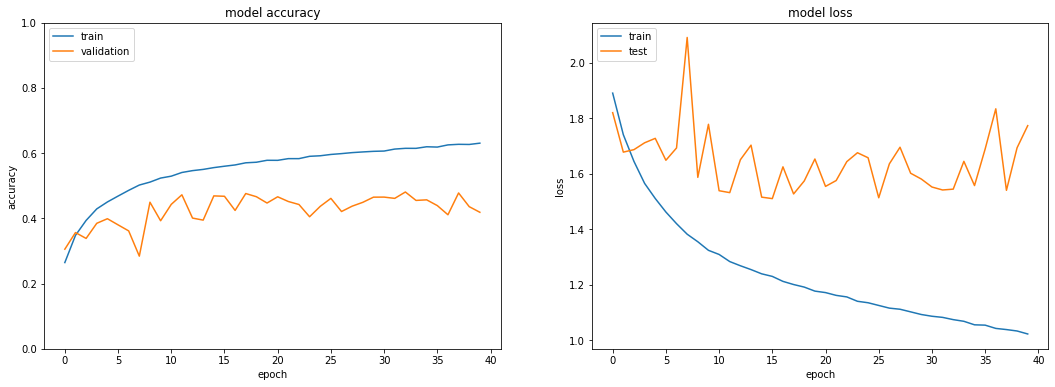

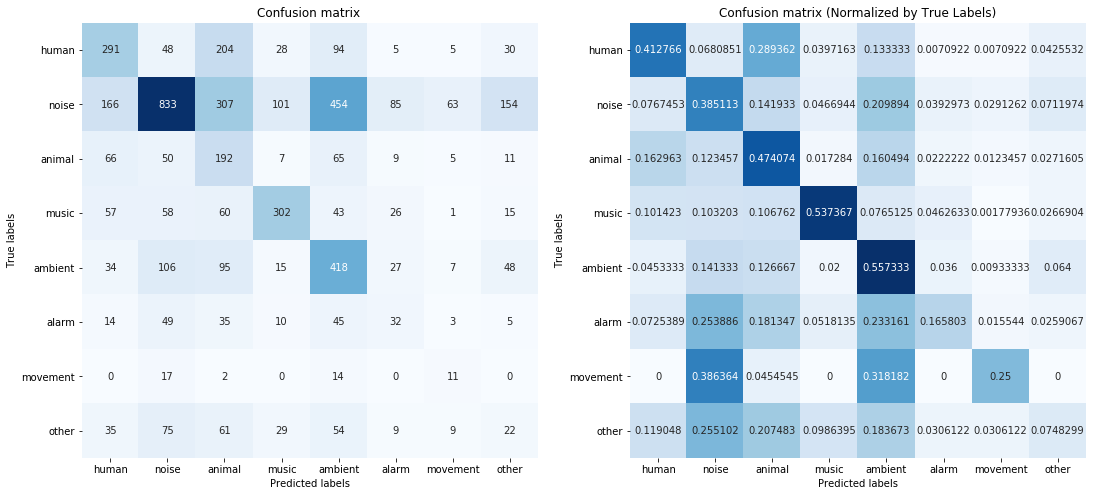

In [23]:
# making predictions on test data and printing classification report:
mfcc_preds = predictions_with_classification_report(model=model, 
                                                           generator=test_mfcc_generator, 
                                                           y_true=test_info.labels)

# plotting model accuracy for training and validation data:
plot_history(history=history)

# plotting a normalizing and non-normalizing confusion matrix::
plot_confusion_matrix(y_true=test_info.labels, y_preds=mfcc_preds)

#### Saving Model

In [24]:
# saving model and model history:
model.save("./data/cnn_mfcc_model.h5")
pickle.dump(history.history, open('./data/cnn_mfcc_model_history.pkl', 'wb'))
    
# Adding precision,recall f1-score to metrics dictionary
metrics_dict['cnn_mfcc_model'] = precision_recall_fscore_support(test_info.labels, mfcc_preds, average='macro') 

# saving model metrics dictionary
pickle.dump(metrics_dict, open('./models/model_metrics_dict.pkl', 'wb'))

print("Saved model to disk") 

Saved model to disk


### Part 2b: MFCC Spectograms Features
### Model: CNN Transfer Learning with ResNet50

In [8]:
# have to load image files with 3 channels (rbg) to fit Resnet50 hyperparameters:

datagen=ImageDataGenerator(rescale=1./255.)      

train_resnet_mfcc_generator=datagen.flow_from_dataframe(
    dataframe= dev_info_resampled,
    directory= 'data/train_mfcc',
    x_col='png_name',
    y_col= 'labels',
    color_mode="rgb",
    batch_size=32,
    seed=42,
    shuffle=True,
    subset='training',
    class_mode="raw", 
    target_size=(32,216)) 


# validation generator
val_resnet_mfcc_generator=datagen.flow_from_dataframe(
    dataframe= validation_info,
    directory= 'data/test_mfcc',
    x_col='png_name',
    y_col= 'labels', 
    color_mode="rgb",
    batch_size=32,
    seed=42,
    shuffle=False,
    class_mode=  "raw", #  'raw' for numeric input
    target_size=(32,216),
    validate_filenames=True) 

# test generator
test_resnet_mfcc_generator=datagen.flow_from_dataframe(
    dataframe= test_info,
    directory= 'data/test_mfcc',
    x_col='png_name',
    y_col= 'labels',
    color_mode="rgb",
    batch_size=32,
    seed=42,
    shuffle=False,
    class_mode="raw", 
    target_size=(32,216)) 

Found 40000 validated image filenames.
Found 5115 validated image filenames.
Found 5116 validated image filenames.


In [9]:
# loading ResNet50 Model with ImageNet Weights

resnet = ResNet50(include_top=False, weights='imagenet', input_shape=(32,216,3))   

# Removing final output layer to add customized trainable layers
output = resnet.layers[-1].output
output = keras.layers.Flatten()(output)
resnet = Model(inputs=resnet.input, outputs=output)

# Unfreezing trainable resnet layers for hyperparameter tuning
for layer in resnet.layers:
    if isinstance(layer, BatchNormalization):
        layer.trainable = True
    else:
        layer.trainable = False
        
# summary of resnet model:

resnet.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 216, 3)] 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 38, 222, 3)   0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 16, 108, 64)  9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 16, 108, 64)  256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [10]:
#instantiating an empty model, loading Resnet50 layers and weights and adding customized layers 

model = Sequential()
model.add(resnet)
model.add(Dense(256, activation='relu')) 
model.add(Dropout(0.25))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(8, activation='softmax'))

# optimizer=SGD(lr=0.02, decay=1e-6, momentum=0.9, nesterov=True)

model.compile(loss=sparse_categorical_crossentropy,
              optimizer=SGD(lr=0.002, decay=1e-6, momentum=0.9, nesterov=True),
              metrics='accuracy')

# summary of resnet model with customized layers
model.summary() 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Functional)           (None, 14336)             23587712  
_________________________________________________________________
dense (Dense)                (None, 256)               3670272   
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0

In [ ]:
start =time.time()
#, validation_data=val_resnet_mfcc_generator
resnet_history = model.fit(x=train_resnet_mfcc_generator, 
                           validation_data=val_resnet_mfcc_generator,
                           epochs=20, 
                           verbose=1)   

end = time.time()
print(end - start)

Epoch 1/20
1250/1250 [==============================] - 359s 285ms/step - loss: 1.9542 - accuracy: 0.2772 - val_loss: 2.0037 - val_accuracy: 0.2373
Epoch 2/20
1250/1250 [==============================] - 356s 285ms/step - loss: 1.6358 - accuracy: 0.4088 - val_loss: 1.7798 - val_accuracy: 0.3464
Epoch 3/20
1250/1250 [==============================] - 356s 285ms/step - loss: 1.5223 - accuracy: 0.4511 - val_loss: 1.7916 - val_accuracy: 0.3380
Epoch 4/20
1250/1250 [==============================] - 355s 284ms/step - loss: 1.4525 - accuracy: 0.4740 - val_loss: 1.7909 - val_accuracy: 0.3521
Epoch 5/20
1250/1250 [==============================] - 356s 285ms/step - loss: 1.3713 - accuracy: 0.5050 - val_loss: 1.8536 - val_accuracy: 0.3566
Epoch 6/20
1250/1250 [==============================] - 355s 284ms/step - loss: 1.2982 - accuracy: 0.5315 - val_loss: 1.7265 - val_accuracy: 0.3705
Epoch 7/20
1250/1250 [==============================] - 355s 284ms/step - loss: 1.2342 - accuracy: 0.5602 - val_

### Model Analysis

classification Report:
              precision    recall  f1-score   support

           0       0.37      0.42      0.39       705
           1       0.60      0.32      0.42      2163
           2       0.19      0.27      0.22       405
           3       0.49      0.48      0.49       562
           4       0.32      0.50      0.39       750
           5       0.13      0.22      0.16       193
           6       0.06      0.39      0.10        44
           7       0.10      0.07      0.09       294

    accuracy                           0.36      5116
   macro avg       0.28      0.34      0.28      5116
weighted avg       0.43      0.36      0.37      5116



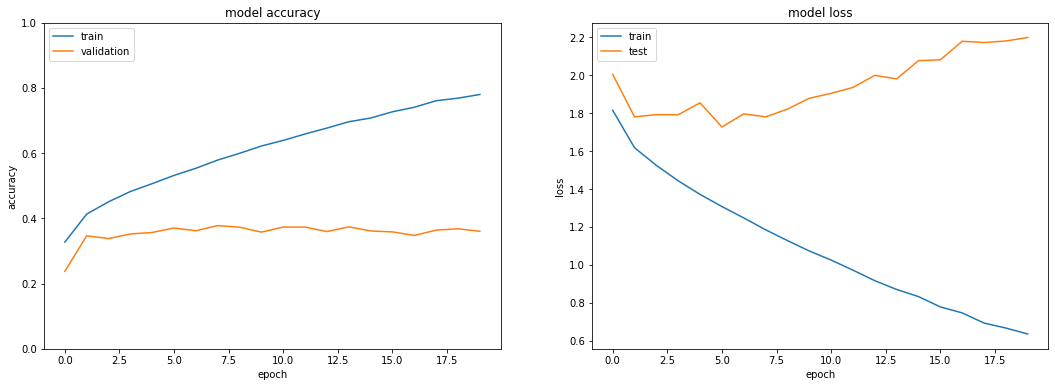

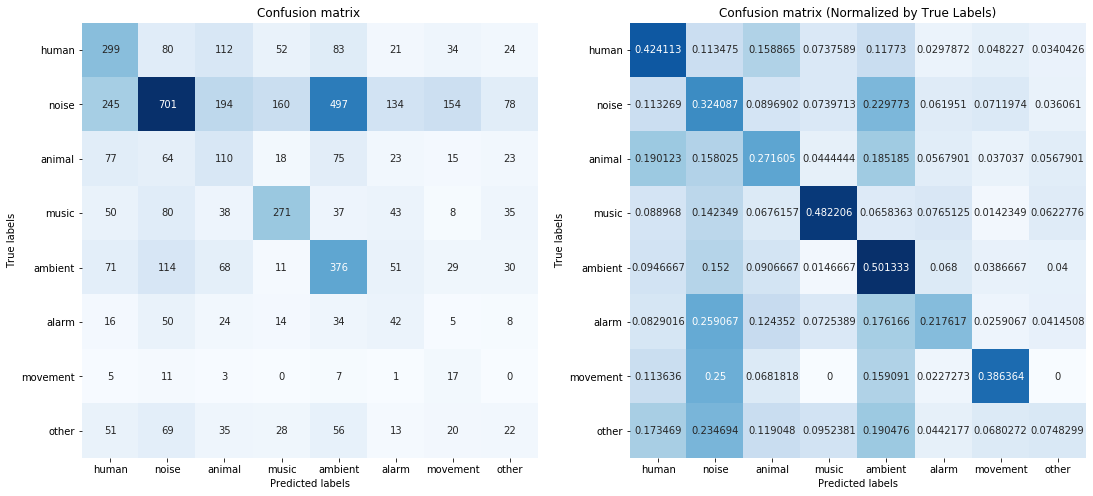

In [13]:
# making predictions on test data and printing classification report:
resnet_preds = predictions_with_classification_report(model=model, 
                                                           generator=test_resnet_mfcc_generator, 
                                                           y_true=test_info.labels)

# plotting model accuracy for training and validation data:
plot_history(history=resnet_history.history)

# plotting a normalizing and non-normalizing confusion matrix::
plot_confusion_matrix(y_true=test_info.labels, y_preds=resnet_preds)

### Saving Model

In [14]:
# saving model and model history:
model.save("./data/cnn_mfcc_resnet_model.h5")
pickle.dump(resnet_history.history, open('./data/cnn_mfcc_resnet_model_history.pkl', 'wb'))
print("Saved model to disk") 
    
# Adding precision,recall f1-score to metrics dictionary
metrics_dict['resnet_mfcc_model'] = precision_recall_fscore_support(test_info.labels, 
                                                                        resnet_preds, 
                                                                        average='macro') 
# saving model metrics dictionary
pickle.dump(metrics_dict, open('./models/model_metrics_dict.pkl', 'wb'))

Saved model to disk


## Part 3 - Mean Mel-Frequency Cepstrum Coefficent Features
- In this section we will use the feature set of the mean MFCC values. -
- This is the average of the Mel-Frequency Cepstrum Coefficients aggegrated over time. Thus for each audio event we have 32 MFC coefficients. 
- Now that no longer have an image but rather a 1-d array of features, we can apply standard classification algorithms to these features. 
- In the section we will train a standard Neural Network, Logistic Regression, Random Forest, and Support Vector Machine Classifier.

#### Loading Training-Validation-Test Features: Numpy Arrays of Mean MFCC values  

In [12]:
# Loading Training Data
X_train = np.load('data/scaled_train_mean_mfcc_values.npz')['arr_0']
y_train = dev_info_resampled['labels'].to_numpy()

# Loading Validation-Test Data for Neural Network hyperparameter tuning
validation_info = pd.read_json('data/nn_validation_info.json')
test_info = pd.read_json('data/nn_validation_info.json')

# Declaring Explanatory Variables
X_val = validation_info.drop(columns=['labels']).to_numpy()
X_test = test_info.drop(columns=['labels']).to_numpy()

# Declaring Response Variables
y_val = validation_info.labels.to_numpy()
y_test = test_info.labels.to_numpy()

# Respons
print(X_val.shape)
print(X_test.shape)

(5116, 32)
(5116, 32)


### Part 3a: Mean MFCC Value Features
### Model: Neural Network

In [37]:
model = Sequential()
model.add(Dense(32, input_dim=32, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.1))
# model.add(Dense(32, activation='relu'))
# model.add(Dropout(0.25))
# model.add(Dense(64, activation='relu'))
# model.add(Dropout(0.25))
model.add(Dense(8, activation='softmax'))


# optimizer='adam', 

# compile the keras model
model.compile(loss=sparse_categorical_crossentropy, 
              optimizer=SGD(lr=0.002, decay=1e-6, momentum=0.9, nesterov=True),
              metrics='accuracy')
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_30 (Dense)             (None, 32)                1056      
_________________________________________________________________
dropout_21 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_31 (Dense)             (None, 64)                2112      
_________________________________________________________________
dropout_22 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_32 (Dense)             (None, 128)               8320      
_________________________________________________________________
dropout_23 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_33 (Dense)             (None, 8)                

In [38]:
nn_history = model.fit(X_train, y_train, validation_data = (X_val, y_val), epochs=50, batch_size=32, verbose=1)

Epoch 1/50
1250/1250 [==============================] - 1s 661us/step - loss: 1.9834 - accuracy: 0.2238 - val_loss: 1.8810 - val_accuracy: 0.3049
Epoch 2/50
1250/1250 [==============================] - 1s 581us/step - loss: 1.8020 - accuracy: 0.3311 - val_loss: 1.8714 - val_accuracy: 0.2924
Epoch 3/50
1250/1250 [==============================] - 1s 619us/step - loss: 1.7438 - accuracy: 0.3553 - val_loss: 1.8354 - val_accuracy: 0.3254
Epoch 4/50
1250/1250 [==============================] - 1s 634us/step - loss: 1.7013 - accuracy: 0.3711 - val_loss: 1.8077 - val_accuracy: 0.3344
Epoch 5/50
1250/1250 [==============================] - 1s 577us/step - loss: 1.6781 - accuracy: 0.3834 - val_loss: 1.8308 - val_accuracy: 0.3149
Epoch 6/50
1250/1250 [==============================] - 1s 577us/step - loss: 1.6602 - accuracy: 0.3894 - val_loss: 1.8555 - val_accuracy: 0.3039
Epoch 7/50
1250/1250 [==============================] - 1s 585us/step - loss: 1.6415 - accuracy: 0.4028 - val_loss: 1.8642 -

### Model Analysis

In [ ]:
# Making predictions on the test set

mean_mfcc_preds =  model.predict(X_test)
mean_mfcc_preds = np.argmax(mean_mfcc_preds, axis=1)

#Classification Report: 
print("classification Report:")
print(classification_report(y_test, mean_mfcc_preds))

classification Report:
              precision    recall  f1-score   support

           0       0.41      0.42      0.42       717
           1       0.73      0.21      0.33      2137
           2       0.25      0.31      0.28       412
           3       0.35      0.69      0.47       552
           4       0.41      0.37      0.39       772
           5       0.12      0.37      0.19       182
           6       0.07      0.63      0.13        63
           7       0.07      0.10      0.09       281

    accuracy                           0.33      5116
   macro avg       0.30      0.39      0.29      5116
weighted avg       0.49      0.33      0.34      5116



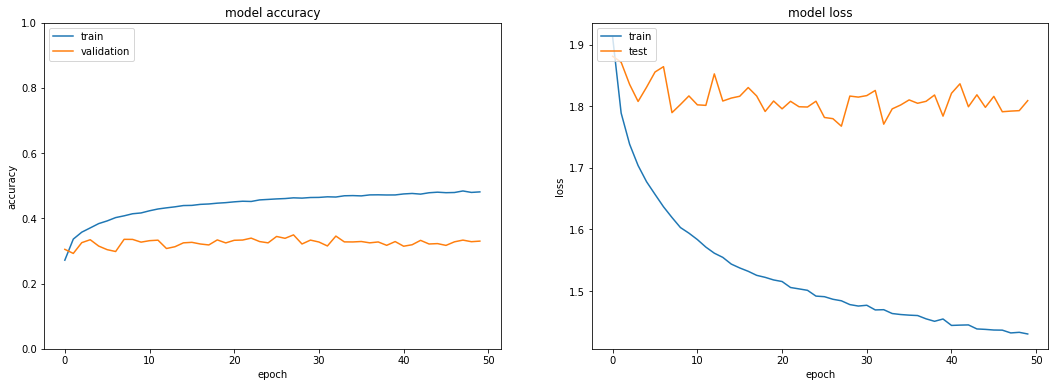

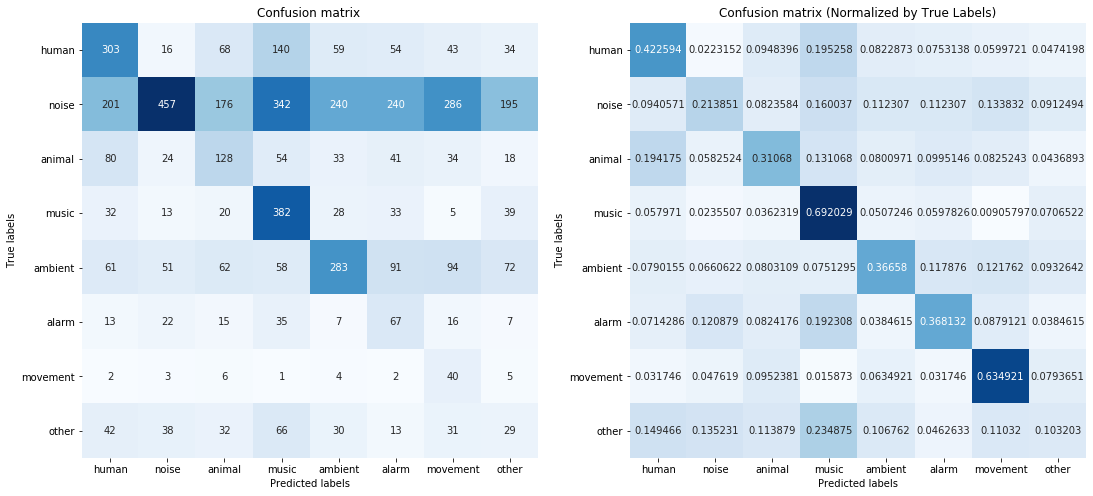

In [39]:
# making predictions on test data and printing classification report:
nn_preds = predictions_with_classification_report(model=model, 
                                                           generator=X_test, 
                                                           y_true=y_test)

# plotting model accuracy for training and validation data:
plot_history(history=nn_history)

# plotting a normalizing and non-normalizing confusion matrix::
plot_confusion_matrix(y_true=y_test, y_preds=nn_preds)

#### Saving Model

In [40]:
# saving model:
model.save("./data/mean_mfcc_nn_model.h5")
print("Saved model to disk") 

# saving model history:
pickle.dump(nn_history.history, open('./data/mean_mfcc_nn_model_history.pkl', 'wb'))
    
# Adding precision,recall f1-score to metrics dictionary
metrics_dict['mean_mfcc_nn_model'] = precision_recall_fscore_support(y_test, nn_preds, average='macro')

# saving model metrics dictionary
pickle.dump(metrics_dict, open('./models/model_metrics_dict.pkl', 'wb'))

Saved model to disk


### Part 3b: Mean MFCC Value Features 
### Model: Logistic Regression
#### Hyperparameters:
- Regularization Penalty: Elastic Net (l1_ratio=0.5)
- Solver: SAGA (extension of Stochastic Average Gradient(SAG) descent with L1 regualization, generally faster than SAG)

In [24]:
# loading  Mean MFCC Train-Test Data features without Validation Split
X_train = np.load('data/scaled_train_mean_mfcc_values.npz')['arr_0']
X_test = np.load('data/scaled_test__mean_mfcc_values.npz')['arr_0']
y_train = dev_info_resampled['labels'].to_numpy()
y_test = eval_info['labels'].to_numpy()

print(X_train.shape)
print(X_test.shape)

print(y_train.shape)
print(y_test.shape)

(40000, 32)
(10231, 32)
(40000,)
(10231,)


In [42]:
## Baseline Model: Logistic Regression

# saga= stochastic average gradient descent
lr = LogisticRegression(penalty= 'elasticnet', solver='saga', l1_ratio= 0.5, max_iter=500)
lr.fit(X_train, y_train)
lr_preds= lr.predict(X_test)

              precision    recall  f1-score   support

           0       0.34      0.22      0.26      1413
           1       0.66      0.24      0.35      4206
           2       0.17      0.14      0.15       829
           3       0.24      0.58      0.34      1168
           4       0.39      0.35      0.37      1559
           5       0.09      0.22      0.13       378
           6       0.04      0.52      0.07       110
           7       0.07      0.05      0.06       568

    accuracy                           0.28     10231
   macro avg       0.25      0.29      0.22     10231
weighted avg       0.42      0.28      0.30     10231



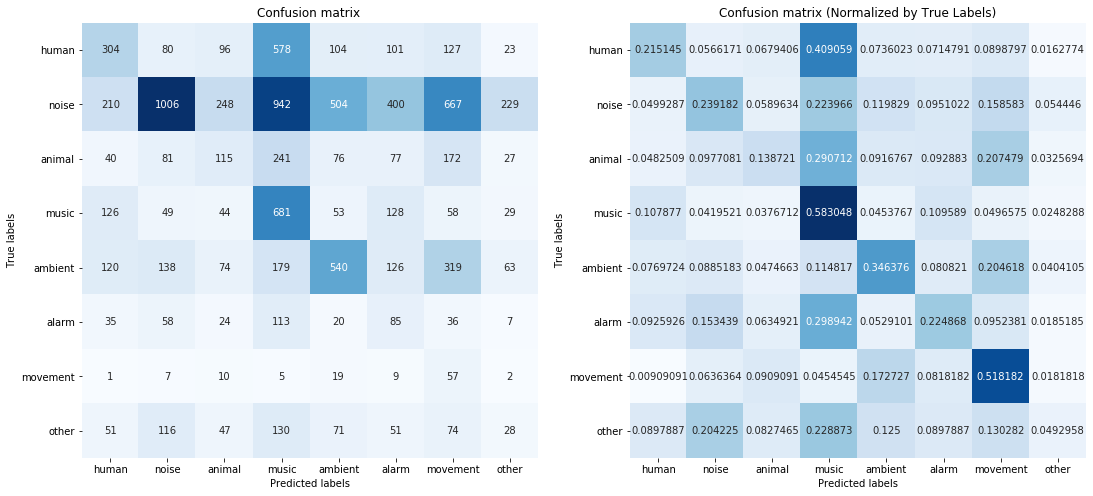

In [48]:
# making predictions on test data and printing classification report:
lr_preds= lr.predict(X_test)
print(classification_report(y_test, lr_preds))

# plotting a normalizing and non-normalizing confusion matrix::
plot_confusion_matrix(y_true=y_test, y_preds=lr_preds)

#### Saving Model

In [55]:
# saving model
pickle.dump(lr, open('./models/logistic_regression_model.pkl', 'wb'))

# Adding precision,recall f1-score to metrics dictionary
metrics_dict['logistic_regression_model'] = precision_recall_fscore_support(y_test, lr_preds, average='macro') 

# saving model metrics dictionary
pickle.dump(metrics_dict, open('./models/model_metrics_dict.pkl', 'wb'))

### Part 3c: Mean MFCC Value Features
### Model: Random Forest
#### Hyperparameters:

- Tuning "n_estimators"(number of trees), "max_features"(number of features to analyze at each split), "max_depth"(number of levels in the tree)
- Employing a Random Grid Search with 3 fold Cross-Validation with 50 iterations

In [14]:
# return to this article on tuning: https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 500, num = 20)]

# Number of features to consider at every split: the binary log or the square root of the number of features
max_features = ['log2', 'sqrt'] 

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 50, num = 11)]
max_depth.append(None)

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth}

In [15]:
start = time.time()

# Using random grid to search for best hyperparameters

# Instantiating the base model
rf = RandomForestClassifier()

# Random search of parameters, using 3 fold cross validation, 
# search across 25 different combinations, use all available cores
rf_random_cv = RandomizedSearchCV(estimator = rf, 
                                  param_distributions = random_grid, 
                                  n_iter = 50, 
                                  cv = 3, 
                                  verbose=1, 
                                  random_state=42, 
                                  n_jobs =-1)

# Fit the random search model
rf_random_cv.fit(X_train, y_train)

stop = time.time()
print(stop - start)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 36 concurrent workers.
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  4.3min finished


360.7337739467621


In [ ]:
# 50 iterations took 6 minutes...

In [17]:
print("Best Parameters:", rf_random_cv.best_params_)

Best Parameters: {'n_estimators': 476, 'max_features': 'sqrt', 'max_depth': 41}


### Model Analysis

              precision    recall  f1-score   support

           0       0.41      0.52      0.46      1413
           1       0.69      0.31      0.43      4206
           2       0.27      0.33      0.29       829
           3       0.42      0.66      0.51      1168
           4       0.36      0.52      0.43      1559
           5       0.14      0.24      0.18       378
           6       0.07      0.37      0.12       110
           7       0.07      0.02      0.04       568

    accuracy                           0.39     10231
   macro avg       0.30      0.37      0.31     10231
weighted avg       0.47      0.39      0.40     10231



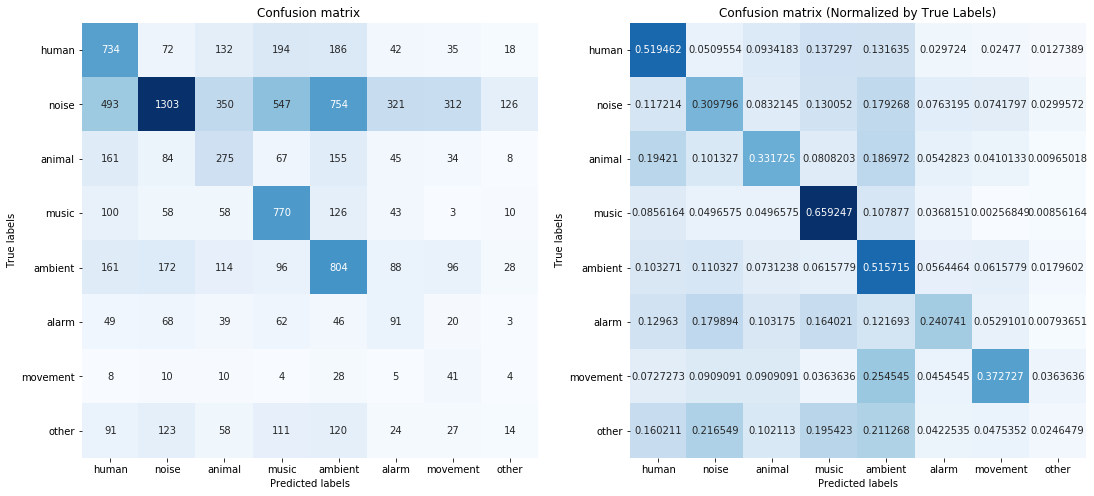

In [18]:
# making predictions on test data and printing classification report:
rf_preds = rf_random_cv.best_estimator_.predict(X_test)
print(classification_report(y_test, rf_preds))

# plotting a normalizing and non-normalizing confusion matrix::
plot_confusion_matrix(y_true=y_test, y_preds=rf_preds)

#### Saving Model

In [22]:
# saving model:
pickle.dump(rf_random_cv, open('./models/random_forest_model.pkl', 'wb'))

# Adding precision,recall f1-score to metrics dictionary
metrics_dict['random_forest_model'] = precision_recall_fscore_support(y_test, rf_preds, average='macro') 

# saving model metrics dictionary
pickle.dump(metrics_dict, open('./models/model_metrics_dict.pkl', 'wb'))

### Part 3d: Mean MFCC Value Features
### Model: Support Vector Machine Classifier
#### Hyperparameters:
 - Tuning the kernel with either "linear" or "rbf", "gamma" from a reciprocal distribution from 0.001 to 1, "C" from a uniform distributin from 0.1 to 100.
 - Employed a Random Grid Search with 3 fold Cross-Validation with 20 iterations.

In [25]:
# alternatively:
start= time.time()

svc = SVC()

# Adding all values of hyperparameters in a list from which the values of hyperparameter
# will randomly inserted as hyperparameter
param_distributions = {"gamma": reciprocal(0.001, 1),
                       "C": uniform(0.1, 10), # 0.1 - 100
                      "kernel": ['linear','rbf']} 
                       

svc_random_cv = RandomizedSearchCV(svc, 
                                   param_distributions, 
                                   n_iter=20, 
                                   verbose=1, 
                                   cv=3, 
                                   n_jobs =-1) 

svc_random_cv.fit(X_train, y_train)

end= time.time()
print(end - start)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 36 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  60 | elapsed: 47.5min remaining:  9.5min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 77.6min finished


4944.266170024872


In [34]:
print("Best estimator:", svc_random_cv.best_estimator_ )
print("\n","Best score:", svc_random_cv.best_score_)

Best estimator: SVC(C=75.0632402332851, break_ties=False, cache_size=200, class_weight=None,
    coef0=0.0, decision_function_shape='ovr', degree=3,
    gamma=0.20592325774251347, kernel='rbf', max_iter=-1, probability=False,
    random_state=None, shrinking=True, tol=0.001, verbose=False)

 Best score: 0.6083503370020128


              precision    recall  f1-score   support

           0       0.37      0.34      0.36      1413
           1       0.63      0.25      0.36      4206
           2       0.21      0.24      0.23       829
           3       0.27      0.82      0.40      1168
           4       0.35      0.34      0.34      1559
           5       0.14      0.20      0.16       378
           6       0.08      0.21      0.11       110
           7       0.05      0.03      0.04       568

    accuracy                           0.33     10231
   macro avg       0.26      0.30      0.25     10231
weighted avg       0.42      0.33      0.32     10231



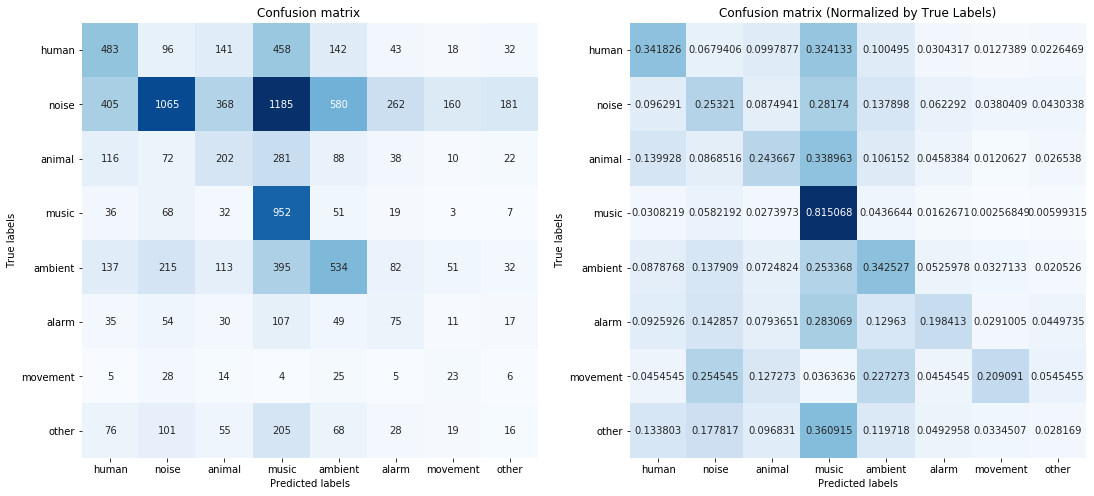

In [35]:
# Making Predictions
svc_preds = svc_random_cv.best_estimator_.predict(X_test)

#Classification Report: 
print(classification_report(y_test, svc_preds))

# plotting a normalizing and non-normalizing confusion matrix::
plot_confusion_matrix(y_true=y_test, y_preds=svc_preds)

#### Saving Model

In [36]:
# saving model:
pickle.dump(svc_random_cv, open('./models/svc_model.pkl', 'wb'))
    
# Adding precision,recall f1-score to metrics dictionary
metrics_dict['svm_model'] = precision_recall_fscore_support(y_test, 
                                                            svc_preds, 
                                                            average='macro') 

In [38]:
# saving model metrics dictionary
pickle.dump(metrics_dict, open('./models/model_metrics_dict.pkl', 'wb'))

In [37]:
metrics_dict

{'logistic_regression_model': (0.2491182711818299,
  0.2893522122588531,
  0.2158337440336253,
  None),
 'random_forest_model': (0.3022823870401209,
  0.3717575394402121,
  0.3059798650336337,
  None),
 'cnn_mfcc_model': (0.3285542250624757,
  0.3571607777858018,
  0.324102920705793,
  None),
 'cnn_spectrogram_model': (0.38247571240037226,
  0.4364574091843614,
  0.39643424244254777,
  None),
 'mean_mfcc_nn_model': (0.30439157683654816,
  0.3889986991983936,
  0.28575574966653505,
  None),
 'resnet_mfcc_model': (0.29227024728107337,
  0.33364429830338616,
  0.289393316746276,
  None),
 'svm_model': (0.2612117882219922,
  0.3039963809155675,
  0.2500909900404513,
  None)}

___
### Review of All Model Metrics:
- Given that the distribution of the test data have imbalanced classes, we use F1-Score as our evaluation metric as it takes into account both precision and recall.

In [41]:
metrics_df = pd.DataFrame(metrics_dict, index=['precision', 'recall', 'f1-score', 'support'])\
            .T.sort_values(by='f1-score', ascending=False)\
            .drop(columns=['support']) # support not applicable for multiclass summary statistics

In [42]:
metrics_df

,precision,recall,f1-score
cnn_spectrogram_model,0.382476,0.436457,0.396434
cnn_mfcc_model,0.328554,0.357161,0.324103
random_forest_model,0.302282,0.371758,0.305980
resnet_mfcc_model,0.292270,0.333644,0.289393
mean_mfcc_nn_model,0.304392,0.388999,0.285756
svm_model,0.261212,0.303996,0.250091
logistic_regression_model,0.249118,0.289352,0.215834


In [44]:
metrics_df.to_json('./models/model_metrics_df.json')

## Next Notebook: Final Model Analysis
- In the nextbook, we will further anlayze the model metrics, the model with the best performance, and review some business recommendations and insights derived from these models.